# Plot the decision surfaces of ensembles of trees on the iris dataset
_This example comes from [sklearn documentation](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html). 
The original source code can be found in [plot_forest_iris.py](http://scikit-learn.org/stable/_downloads/plot_forest_iris.py)._

####We're going to plot the decision surfaces of forests of randomized trees trained on pairs of features of the iris dataset.

This plot compares the decision surfaces learned by
- a decision tree classifier (first column), 
- a random forest classifier (second column), 
- an extra-trees classifier (third column) and
- an AdaBoost classifier (fourth column).

We'll only use subset of features: The classifiers are built 
- using the sepal width and the sepal length features only (first row),
- using the petal length and sepal length only (second row), and
- using the petal width and the petal length only (third row).

It is worth noting that RandomForests and ExtraTrees can be fitted in parallel
on many cores as each tree is built independently of the others. AdaBoost's
samples are built sequentially and so do not use multiple cores.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import clone
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

DecisionTree with features sepal length, sepal width has a score of 0.9267
RandomForest with 30 estimators with features sepal length, sepal width has a score of 0.9267
ExtraTrees   with 30 estimators with features sepal length, sepal width has a score of 0.9267
AdaBoost     with 30 estimators with features sepal length, sepal width has a score of 0.8600
DecisionTree with features sepal length, petal length has a score of 0.9933
RandomForest with 30 estimators with features sepal length, petal length has a score of 0.9933
ExtraTrees   with 30 estimators with features sepal length, petal length has a score of 0.9933
AdaBoost     with 30 estimators with features sepal length, petal length has a score of 0.9933
DecisionTree with features petal length, petal width has a score of 0.9933
RandomForest with 30 estimators with features petal length, petal width has a score of 0.9933
ExtraTrees   with 30 estimators with features petal length, petal width has a score of 0.9933
AdaBoost     with 3

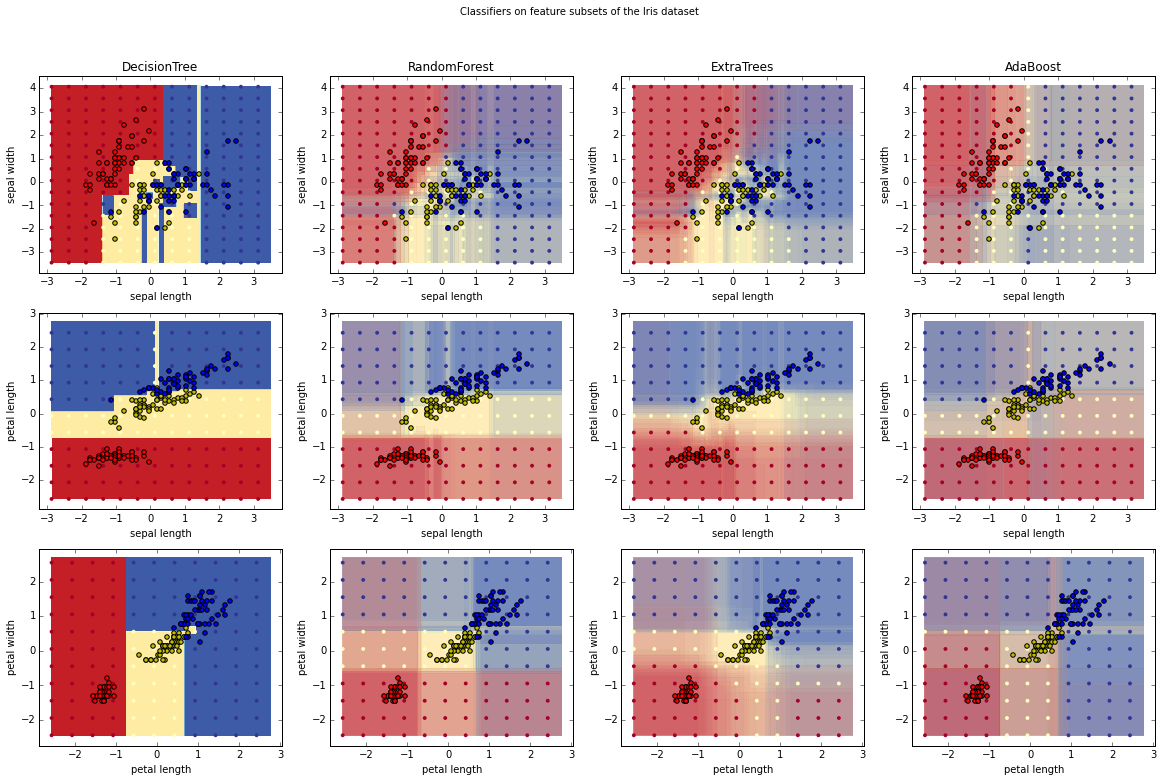

In [2]:
# Parameters
n_classes = 3
n_estimators = 30
plot_colors = "ryb"
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data and initialize models
iris = load_iris()
models = [DecisionTreeClassifier(max_depth=None),
          RandomForestClassifier(n_estimators=n_estimators),
          ExtraTreesClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                             n_estimators=n_estimators)]
plot_idx = 1
plt.figure(figsize=(20,12))
for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize: features will be centered around 0 with 1 standard deivation
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        clf = clone(model)
        clf = model.fit(X, y)

        scores = clf.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")]
        model_details = "%-12s" % model_title  # fill spaces to align text
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(len(model.estimators_))
        feature_names = [iris.feature_names[i][:-5] for i in pair]  # drop the "(cm)" part
        print model_details + " with features", ", ".join(feature_names), "has a score of %.4f" % scores
        
        plt.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a black outline
        xx_coarser, yy_coarser = np.meshgrid(np.arange(x_min, x_max, plot_step_coarser),
                                             np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(), yy_coarser.ravel()]).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15, c=Z_points_coarser, cmap=cmap, edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        for i, c in zip(xrange(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=c, label=iris.target_names[i],
                        cmap=cmap)
        
        plt.xlabel(feature_names[0])
        plt.ylabel(feature_names[1])
        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the Iris dataset")
plt.axis("tight")
plt.show()

In descending order of quality, when trained (outside of this example) on all
4 features using 30 estimators and scored using 10 fold cross validation, we see::

    ExtraTreesClassifier()  # 0.95 score
    RandomForestClassifier()  # 0.94 score
    AdaBoost(DecisionTree(max_depth=3))  # 0.94 score
    DecisionTree(max_depth=None)  # 0.94 score

Increasing `max_depth` for `AdaBoost` lowers the standard deviation of the scores (but
the average score does not improve).

### Exercises

1. vary the ``max_depth`` for the ``DecisionTreeClassifier`` and
   ``AdaBoostClassifier``. (Perhaps try ``max_depth=3`` for the
   ``DecisionTreeClassifier`` or ``max_depth=None`` for ``AdaBoostClassifier``)
1. vary ``n_estimators``